In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pandas as pd
import keras
import numpy as np
import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device




In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
RANDOM_SEED = 42
MAX_LEN = 256
BATCH_SIZE = 4
EPOCHS = 2

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [ ]:
token_lens = []

for txt in train.combinedText:
  tokens = tokenizer.encode(txt, max_length=MAX_LEN)
  token_lens.append(len(tokens))


In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 1000]);
plt.xlabel('Token count');

In [6]:
class GPReviewDataset(Dataset):

  def __init__(self, combinedTexts, stances, tokenizer, max_len):
    self.combinedTexts = combinedTexts
    self.stances = stances
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.combinedTexts)
  
  def __getitem__(self, item):
    combinedText = str(self.combinedTexts[item])
    stance = self.stances[item]

    encoding = self.tokenizer.encode_plus(
      combinedText,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'combinedText': combinedText,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'stances': torch.tensor(stance, dtype=torch.long)
    }

In [7]:
df_train, df_test = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [8]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    combinedTexts=df.combinedText.to_numpy(),
    stances=df.Stance.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
# BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
competition_test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
class StanceClassifier(nn.Module):

  def __init__(self, n_classes):
    super(StanceClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = ['0', '1', '2', '3']
model = StanceClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [ ]:
# EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [22]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    stances = d["stances"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, stances)

    correct_predictions += torch.sum(preds == stances)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stances = d["stances"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, stances)

      correct_predictions += torch.sum(preds == stances)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [26]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  combinedTexts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["combinedText"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stances = d["stances"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      combinedTexts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(stances)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return combinedTexts, predictions, prediction_probs, real_values

In [ ]:
y_combinedTexts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
y_combinedTexts_competition, y_pred_competition, y_pred_probs_competition, y_test_competition = get_predictions(
  model,
  competition_test_data_loader
)

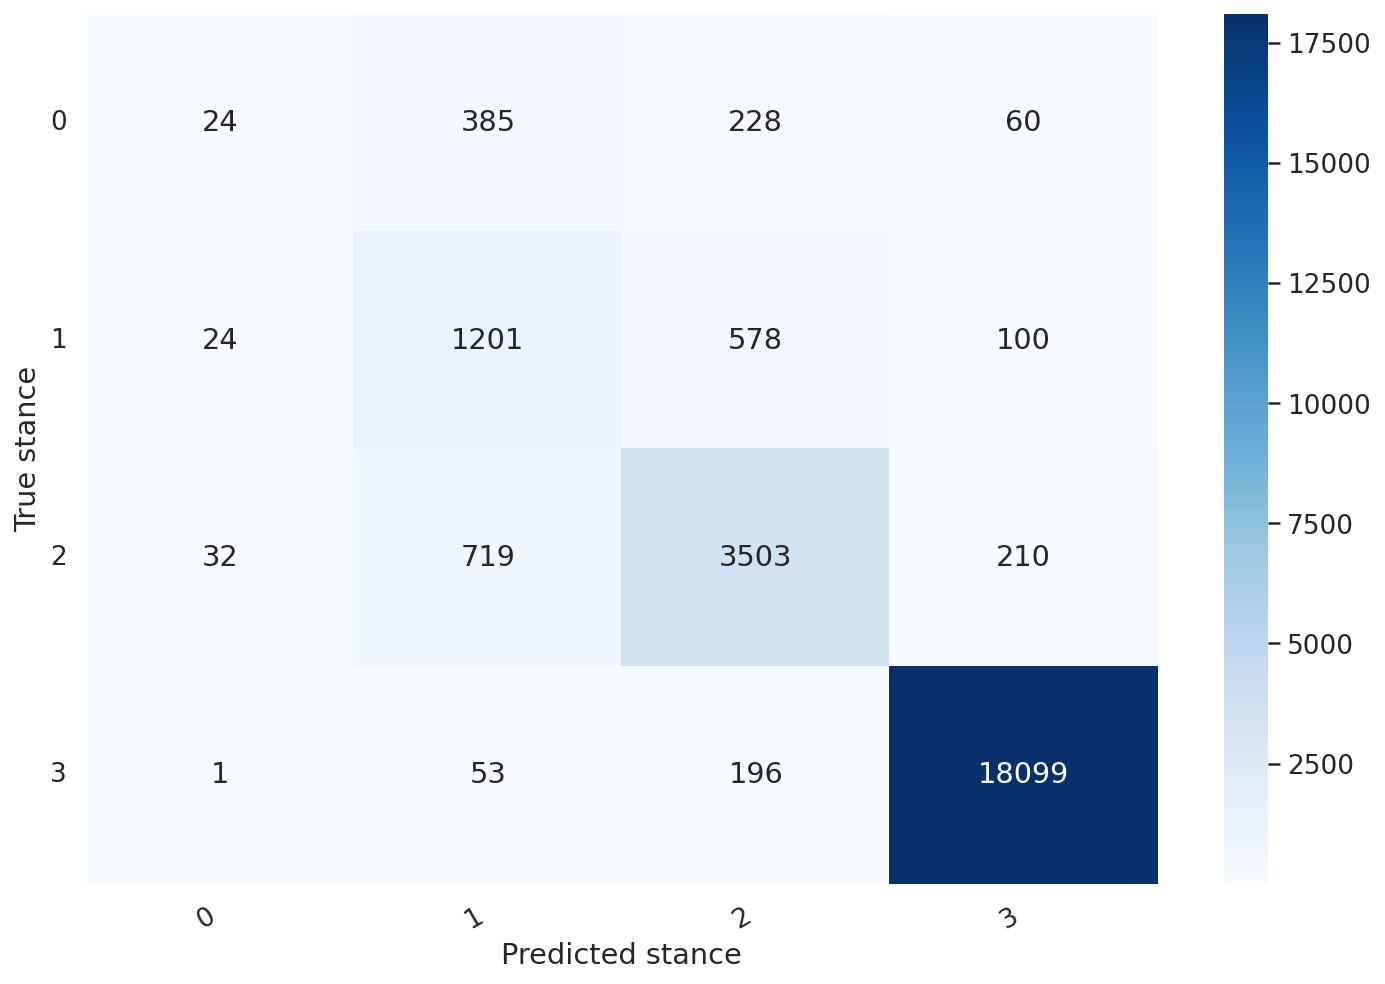

In [30]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True stance')
  plt.xlabel('Predicted stance');

cm = confusion_matrix(y_test_competition, y_pred_competition)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [31]:
y_classes = []

for i in range(len(y_pred_competition)):
    if y_pred_competition[i] == 0: y_classes.append("disagree")
    
    if y_pred_competition[i] == 1: y_classes.append("agree")
    
    if y_pred_competition[i] == 2: y_classes.append("discuss")
    
    if y_pred_competition[i] == 3: y_classes.append("unrelated")
    

In [34]:
answers = pd.DataFrame()
answers['Headline'] = test['Headline']
answers['Body ID'] = test['Body ID']
answers['Stance'] = y_classes
answers.to_csv('data/answer.csv', index=False, encoding='utf-8')